In [1]:
import torch
print("PyTorch Version:", torch.__version__)

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


PyTorch Version: 2.5.1+cu121
Device: cuda


In [2]:
import pickle
import os
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from torchvision import models
from torch.amp import GradScaler, autocast
import random
import time
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
# Preprocessing for Dataset 1 (WM811K)
def preprocess_wm811k_data(path_to_dataset, target_size=(32, 32), num_classes=8, multi_label_ratio = 0.5):
    """
    Load and preprocess the WM811K dataset and generate synthetic multi-label data.

    Parameters:
        path_to_dataset (str): Path to the WM811K .pkl dataset.
        target_size (tuple): Desired image size.
        num_classes (int): Total number of classes.
        multi_label_ratio (float): Fraction of multi-label samples to generate.

    Returns:
        np.ndarray: Preprocessed wafer maps.
        np.ndarray: Multi-label one-hot encoded labels.
    """
    df = pd.read_pickle(path_to_dataset)
    df = df.drop(['waferIndex'], axis=1)
    #df['waferMapDim'] = df['waferMap'].apply(lambda x: (np.size(x, axis=0), np.size(x, axis=1)))
    df['failureNum'] = df['failureType']

    mapping_type = {
        'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
        'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': -1}
    df = df.replace({'failureNum': mapping_type})
    #df_withpattern = df[(df['failureNum'] >= 0)].reset_index()

    # Filter out invalid data
    valid_indices = df["failureNum"].apply(lambda x: x is not None and isinstance(x, (int, np.integer)))
    df = df[valid_indices]

    wafer_maps = df['waferMap'].to_numpy()
    labels = df['failureNum'].to_numpy()

    processed_maps = []
    for wafer_map in wafer_maps:
        if wafer_map.size == 0:  # Skip invalid or empty maps
            continue
        wafer_map = np.array(wafer_map, dtype=np.float32)
        wafer_map = (wafer_map - np.min(wafer_map)) / (np.max(wafer_map) - np.min(wafer_map))
        scaling_factor = min(target_size[1] / wafer_map.shape[1], target_size[0] / wafer_map.shape[0])
        new_width = int(wafer_map.shape[1] * scaling_factor)
        new_height = int(wafer_map.shape[0] * scaling_factor)
        resized_map = cv2.resize(wafer_map, (new_width, new_height), interpolation=cv2.INTER_AREA)
        padded_map = np.full(target_size, 0, dtype=np.float32)
        x_offset = (target_size[1] - new_width) // 2
        y_offset = (target_size[0] - new_height) // 2
        padded_map[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_map
        processed_maps.append(padded_map)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    labels = labels.reshape(-1, 1)  # Reshape for one-hot encoding
    
    # Separate 'none' and encode others
    is_none = labels == -1
    one_hot_labels = encoder.fit_transform(labels[~is_none].reshape(-1,1))
    final_labels = np.zeros((len(labels), num_classes), dtype=np.float32)
    final_labels[~is_none.flatten()] = one_hot_labels

    #one_hot_labels = encoder.fit_transform(labels)

    # Pad one-hot labels to 38 dimensions
    #padded_labels = np.zeros((len(one_hot_labels), num_classes))
    #padded_labels[:, :one_hot_labels.shape[1]] = one_hot_labels

    # Generate synthetic multi-label samples directly without oversampling
    num_samples = len(processed_maps)
    print(num_samples)
    num_multi_class_samples = int(multi_label_ratio * num_samples)
    multi_class_maps = []
    multi_class_labels = []

    for _ in range(num_multi_class_samples):
         #Randomly select two or more samples to combine
        indices = np.random.choice(len(processed_maps), size=2, replace=False)
        
        # Combine maps with consistent dimensions
        combined_map = np.maximum(processed_maps[indices[0]], processed_maps[indices[1]])
        combined_label = np.logical_or(final_labels[indices[0]], final_labels[indices[1]]).astype(np.float32)
        #combined_label = np.logical_or(one_hot_labels[indices[0]], one_hot_labels[indices[1]]).astype(np.float32)

        # Ensure padding for consistency
        resized_combined_map = cv2.resize(combined_map, target_size, interpolation=cv2.INTER_AREA)
        multi_class_maps.append(resized_combined_map)
        multi_class_labels.append(combined_label)

        # Pad synthetic labels to match 38 dimensions
        #padded_combined_label = np.zeros(num_classes)
        #padded_combined_label[:combined_label.shape[0]] = combined_label
        #multi_label_maps.append(combined_map)
        #multi_label_labels.append(combined_label)  #change this
        
    # Combine original and synthetic data
    all_maps = np.vstack([np.array(processed_maps), np.array(multi_class_maps)])
    all_labels = np.vstack([final_labels, np.array(multi_class_labels)])

    return np.expand_dims(all_maps, axis=1), all_labels

    # Combine original and synthetic data
    all_maps = np.vstack([np.expand_dims(processed_maps, axis=1), np.expand_dims(multi_label_maps, axis=1)])
    #all_maps = np.vstack([np.array(processed_maps), np.array(multi_label_maps)])
    #all_labels = np.vstack([padded_labels, np.array(multi_label_labels)])
    all_labels = np.vstack([one_hot_labels, multi_label_labels])
    print(f"Original data shape: {np.array(processed_maps).shape}")
    print(f"Synthetic data shape: {np.array(multi_label_maps).shape}")
    #print(f"Original label shape: {padded_labels.shape}")
    print(f"Synthetic label shape: {np.array(multi_label_labels).shape}")
    

    #return np.expand_dims(all_maps, axis=1), all_labels
    return all_maps, all_labels


    # Oversampling for balanced dataset
    combined = [(x, y) for x, y in zip(processed_maps, labels)]
    class_samples = {cls: [sample for sample in combined if sample[1] == cls] for cls in np.unique(labels)}
    max_class_size = max(len(samples) for samples in class_samples.values())
    oversampled_samples = []
    for cls, samples in class_samples.items():
        oversampled_samples.extend(resample(samples, replace=True, n_samples=max_class_size, random_state=42))
    np.random.shuffle(oversampled_samples)

    # Generate synthetic multi-label samples
    num_samples = len(oversampled_samples)
    num_multi_label_samples = int(multi_label_ratio * num_samples)

    multi_label_maps = []
    multi_label_labels = []

    for _ in range(num_multi_label_samples):
        # Randomly select two or more samples to combine
        indices = np.random.choice(len(oversampled_samples), size=2, replace=False)
        combined_map = np.maximum(oversampled_samples[indices[0]][0], oversampled_samples[indices[1]][0])
        combined_label = np.logical_or(oversampled_samples[indices[0]][1], oversampled_samples[indices[1]][1]).astype(np.float32)

        multi_label_maps.append(combined_map)
        multi_label_labels.append(combined_label)

    # Combine original and synthetic data
    all_maps = np.vstack([np.array([sample[0] for sample in oversampled_samples]), multi_label_maps])
    all_labels = np.vstack([np.array([sample[1] for sample in oversampled_samples]), multi_label_labels])

    return np.expand_dims(all_maps, axis=1), all_labels

In [4]:
# Preprocessing for Dataset 2 (MixedWM38)
def preprocess_npz_dataset(path, target_size=(32, 32), num_classes= 8):
    """
    Preprocess the .npz dataset for mixed-type wafer maps.

    Parameters:
        path (str): Path to the .npz dataset.
        target_size (tuple): Desired image size.

    Returns:
        np.ndarray: Preprocessed wafer maps.
        np.ndarray: Multi-label one-hot encoded labels.
    """
    data = np.load(path)
    wafer_maps = data['arr_0']
    multi_labels = data['arr_1']

    processed_maps = []
    for wafer_map in wafer_maps:
        wafer_map = np.array(wafer_map, dtype=np.float32)
        wafer_map = (wafer_map - np.min(wafer_map)) / (np.max(wafer_map) - np.min(wafer_map))
        resized_map = cv2.resize(wafer_map, target_size, interpolation=cv2.INTER_AREA)
        processed_maps.append(resized_map)

    # One-hot encode multi-labels, excluding 'none'
    multi_label_one_hot = np.zeros((len(multi_labels), num_classes), dtype=np.float32)
    for i, label in enumerate(multi_labels):
        for defect in label.nonzero()[0]:
            if defect < num_classes:  # Exclude "none" from encoding
                multi_label_one_hot[i, defect] = 1

    return np.expand_dims(np.array(processed_maps), axis=1), multi_label_one_hot

    # Pad labels to match the model's expected number of classes
    #padded_labels = np.zeros((labels.shape[0], num_classes))
    #padded_labels[:, :labels.shape[1]] = labels

    #processed_maps = np.expand_dims(processed_maps, axis=1)
    #return np.array(processed_maps), padded_labels
    #return np.expand_dims(processed_maps, axis=1), labels

In [5]:

# train_data, train_labels = preprocess_wm811k_data("data/WM811K.pkl",target_size=(32, 32), num_classes=8, multi_label_ratio=0.5)
# test_data, test_labels = preprocess_npz_dataset("data/MLWM38K.npz", target_size=(32, 32), num_classes=8)

# # Save train data and labels
# np.savez_compressed("data/preprocessed_train_data.npz", data=train_data, labels=train_labels)

# # Save test data and labels
# np.savez_compressed("data/preprocessed_test_data.npz", data=test_data, labels=test_labels)

# print("Preprocessed data saved successfully!")



In [6]:
print("Preprocessed data loaded successfully!")
# Load train data and labels
train_data = np.load("data/preprocessed_train_data.npz")['data']
train_labels = np.load("data/preprocessed_train_data.npz")['labels']
print(f"Train Data Shape: {train_data.shape}, Train Labels Shape: {train_labels.shape}")

# Load test data and labels
test_data = np.load("data/preprocessed_test_data.npz")['data']
test_labels = np.load("data/preprocessed_test_data.npz")['labels']
print(f"Test Data Shape: {test_data.shape}, Test Labels Shape: {test_labels.shape}")

Preprocessed data loaded successfully!
Train Data Shape: (259425, 1, 32, 32), Train Labels Shape: (259425, 8)
Test Data Shape: (38015, 1, 32, 32), Test Labels Shape: (38015, 8)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(data, labels, num_samples=5, dataset_name="Dataset"):
    """
    Visualizes random samples from the dataset with their labels.

    Parameters:
        data (np.ndarray): Wafer map data (preprocessed).
        labels (np.ndarray): Corresponding labels (one-hot encoded).
        num_samples (int): Number of samples to visualize.
        dataset_name (str): Name of the dataset for title purposes.
    """
    num_classes = labels.shape[1]
    indices = np.random.choice(len(data), size=num_samples, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices):
        wafer_map = data[idx].squeeze()  # Remove channel dimension
        label = labels[idx]

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(wafer_map, cmap='gray')
        label_text = ', '.join([f"Class {j}" for j in range(num_classes) if label[j] == 1])
        plt.title(f"Sample {idx}\n{label_text if label_text else 'None'}")
        plt.axis('off')

    plt.suptitle(f"Random Samples from {dataset_name}")
    plt.tight_layout()
    plt.show()



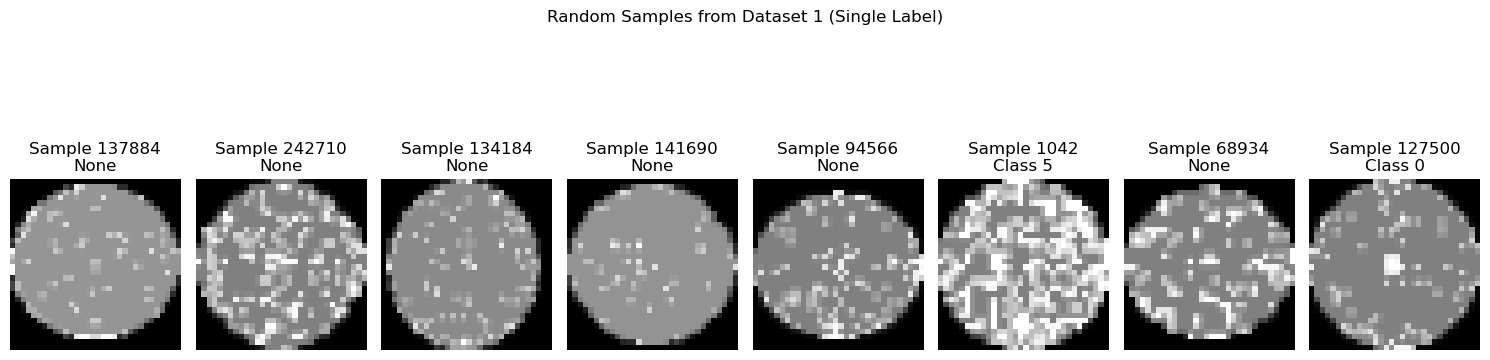

In [8]:
# Visualize Dataset 1
visualize_samples(train_data, train_labels, num_samples=8, dataset_name="Dataset 1 (Single Label)")



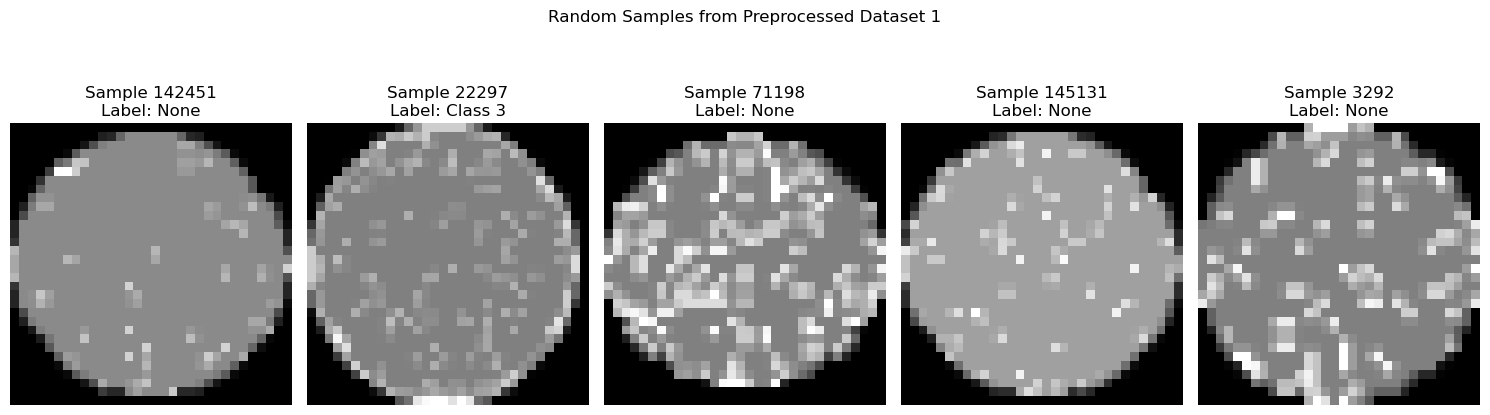

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_preprocessed_samples(data, labels, num_samples=5):
    """
    Visualizes random samples from the preprocessed Dataset 1 with their labels.

    Parameters:
        data (np.ndarray): Preprocessed wafer map data (shape: [num_samples, 1, 32, 32]).
        labels (np.ndarray): One-hot encoded labels corresponding to the wafer maps.
        num_samples (int): Number of samples to visualize.
    """
    # Randomly select indices
    indices = np.random.choice(len(data), size=num_samples, replace=False)

    # Visualize the samples
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        wafer_map = data[idx].squeeze()  # Remove channel dimension
        label = labels[idx]

        # Decode the one-hot label
        label_text = ', '.join([f"Class {j}" for j in range(len(label)) if label[j] == 1])

        # Plot the wafer map
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(wafer_map, cmap='gray')
        plt.title(f"Sample {idx}\nLabel: {label_text if label_text else 'None'}")
        plt.axis('off')

    plt.suptitle("Random Samples from Preprocessed Dataset 1")
    plt.tight_layout()
    plt.show()

# Visualize samples from preprocessed Dataset 1
visualize_preprocessed_samples(train_data, train_labels, num_samples=5)


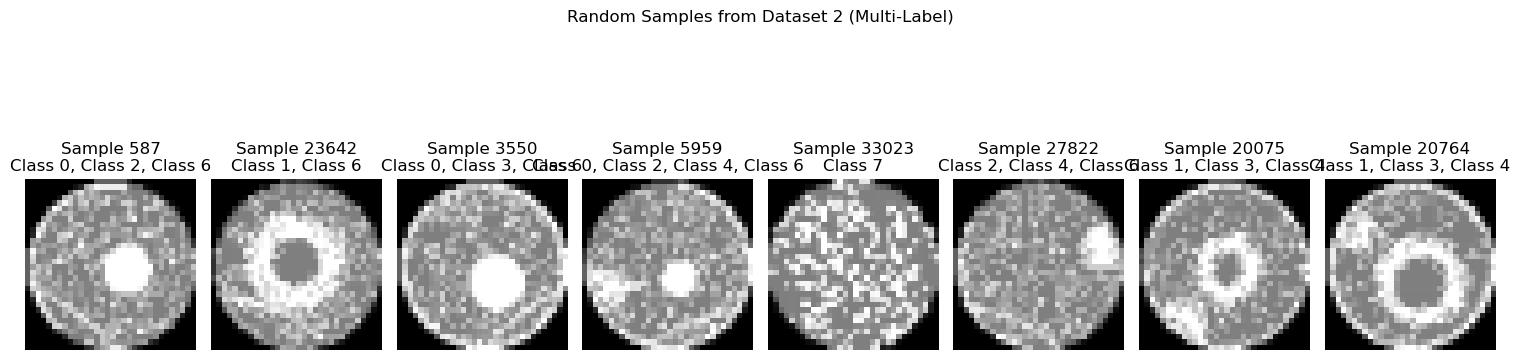

In [10]:
# Visualize Dataset 2
visualize_samples(test_data, test_labels, num_samples=8, dataset_name="Dataset 2 (Multi-Label)")


In [11]:
# Sum along the first axis (rows) to get the count of samples for each class
class_counts = train_labels.sum(axis=0)

# Normalize to get the proportion of each class
class_proportions = class_counts / train_labels.shape[0]

print("Class Counts:", class_counts)
print("Class Proportions:", class_proportions)

Class Counts: [ 8606.  1098. 10358. 19093.  7082.  1693.  2375.   292.]
Class Proportions: [0.03317336 0.00423244 0.03992676 0.07359738 0.02729883 0.00652597
 0.00915486 0.00112557]


In [12]:
# Sum along the first axis (rows) to count occurrences of each class across all samples
class_counts = test_labels.sum(axis=0)

# Normalize to get proportions
class_proportions = class_counts / test_labels.shape[0]

print("Class Counts:", class_counts)
print("Class Proportions:", class_proportions)


Class Counts: [13000. 12000. 13000. 12000. 18000.   149. 19000.   866.]
Class Proportions: [0.34197026 0.31566486 0.34197026 0.31566486 0.4734973  0.00391951
 0.4998027  0.02278048]


In [13]:
# Custom Dataset for PyTorch
class WaferDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [14]:
class VGG16Classifier(nn.Module):
    def __init__(self, init_weights=True, num_classes= 8, feature_dim=512):
        """
        VGG16-based Classifier for multi-label classification.

        Parameters:
            init_weights (bool): Whether to initialize weights.
            num_class (int): Number of output classes.
            feature_dim (int): Feature dimensionality from the feature extractor.
        """
        super(VGG16Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(feature_dim, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten features for linear layers
        x = self.classifier(x)
        return torch.sigmoid(x)  # Sigmoid for multi-label classification

    def _initialize_weights(self):
        """
        Initializes the weights of the classifier layers.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [15]:
'''class EarlyStopping:
    """
    Early stopping to stop training when the training loss does not improve after a given patience.
    """
    def __init__(self, patience=5, delta=0, verbose=False, path="data/checkpoint.pth"):
        """
        Args:
            patience (int): How many epochs to wait after the last improvement in training loss.
            delta (float): Minimum change in the monitored quantity to be considered as improvement.
            path (str): Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verose = verbose
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model_component):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save only the model component (feature_extractor or classifier)
            torch.save(model_component.state_dict(), self.path)
            if self.verbose:
                print("Model improved. Saving...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True'''


'class EarlyStopping:\n    """\n    Early stopping to stop training when the training loss does not improve after a given patience.\n    """\n    def __init__(self, patience=5, delta=0, verbose=False, path="data/checkpoint.pth"):\n        """\n        Args:\n            patience (int): How many epochs to wait after the last improvement in training loss.\n            delta (float): Minimum change in the monitored quantity to be considered as improvement.\n            path (str): Path to save the best model.\n        """\n        self.patience = patience\n        self.delta = delta\n        self.path = path\n        self.verose = verbose\n        self.best_loss = float("inf")\n        self.counter = 0\n        self.early_stop = False\n\n    def __call__(self, val_loss, model_component):\n        if val_loss < self.best_loss - self.delta:\n            self.best_loss = val_loss\n            self.counter = 0\n            # Save only the model component (feature_extractor or classifier)\n   

In [16]:
class CDADA:
    def __init__(self, train_data, train_labels,test_data,test_labels, num_classes = 8, max_epoch=50, batch_size=32, learning_rate=0.0001, subset_size=None):
        """
        Initializes the CDADA training and evaluation pipeline.

        Parameters:
            train_data (np.ndarray): Training data.
            train_labels (np.ndarray): Labels for the training data.
            test_data (np.ndarray): Testing data.
            test_labels (np.ndarray): Labels for the testing data.
            num_classes (int): Number of classes for multi-label classification.
            max_epoch (int): Maximum number of epochs.
            batch_size (int): Batch size for training and testing.
            learning_rate (float): Learning rate for optimizers.
        """
        # Create subset if subset_size is specified
        if subset_size is not None:
            indices = np.random.choice(len(train_data), subset_size, replace=False)
            train_data, train_labels = train_data[indices], train_labels[indices]
            self.train_loader = DataLoader(WaferDataset(train_data, train_labels), batch_size=batch_size, shuffle=True, drop_last=True)
        else:
            # Use full dataset
            self.train_loader = DataLoader(WaferDataset(train_data, train_labels), batch_size=batch_size, shuffle=True,drop_last=True)
        #self.train_loader = DataLoader(WaferDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(WaferDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)
        self.num_classes = num_classes
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
    
        # Initialize VGG16 model
        #model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
        model = models.vgg16(pretrained=True)
        model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Modify for grayscale input
        self.feature_extractor = model.features.to(device)
        self.classifier = VGG16Classifier(num_classes=num_classes).to(device)

        #optimizer and loss
        self.optimizer = optim.Adam(list(self.feature_extractor.parameters()) + list(self.classifier.parameters()), lr=learning_rate) #weight_decay=1e-4
        #self.optimizer = optim.Adam(self.classifier.parameters(), lr=learning_rate)

        # Compute class weights
        class_counts = train_labels.sum(axis=0)  # Sum occurrences for each class
        total_samples = len(train_labels)
        class_weights = total_samples / (num_classes * class_counts)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

        self.criterion = nn.BCEWithLogitsLoss(pos_weight=self.class_weights)

        # Learning Rate Scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    def reset_grad(self):
        self.opt_generator.zero_grad()
        self.opt_classifier.zero_grad()

    def train(self):
        """
        Trains the model with the weighted loss function.
        """
        self.feature_extractor.train()
        self.classifier.train()

        # Initialize early stopping objects for feature extractor and classifier
        #early_stopping_extractor = EarlyStopping(patience=5, verbose=True, path="data/feature_extractor_checkpoint.pt")
        #early_stopping_classifier = EarlyStopping(patience=5, verbose=True, path="data/classifier_checkpoint.pt")

        for ep in range(self.max_epoch):
            time_start = time.time()
            running_loss = 0

            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)

                self.optimizer.zero_grad()
                
                #forward pass
                features = self.feature_extractor(images)
                outputs = self.classifier(features)

                #loss and optimization
                loss = self.criterion(outputs, labels)
                loss.backward()

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(self.feature_extractor.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(self.classifier.parameters(), max_norm=1.0)

                #self.optimizer.zero_grad()
                self.optimizer.step()

                running_loss += loss.item()
            
            # Average training loss
            
            time_end = time.time()
            time_cost = time_end - time_start
            
            print(f"Epoch {ep + 1}/{self.max_epoch}, Loss: {running_loss:.4f}, Time: {time_cost:.2f}s")

            # Early stopping based on training loss
            # early_stopping_extractor(running_loss, self.feature_extractor)
            # if early_stopping_extractor.early_stop:
            #     print("Early stopping triggered!")
            #     break

            # # Early stopping for classifier
            # early_stopping_classifier(running_loss, self.classifier)
            # if early_stopping_classifier.early_stop:
            #     print("Early stopping triggered for classifier!")
            #     break

    def test(self):
        """
        Tests the model and computes accuracy, precision, recall, and F1 score..
        """
        self.feature_extractor.eval()
        self.classifier.eval()

        all_labels = []
        all_outputs = []
        all_images = []

        total_samples = 0
        correct_predictions = 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(device), labels.to(device)

                features = self.feature_extractor(images)
                outputs = self.classifier(features)

                all_labels.append(labels.cpu())
                all_outputs.append(torch.sigmoid(outputs).cpu())
                all_images.append(images.cpu)
                

        all_labels = torch.cat(all_labels)
        all_outputs = torch.cat(all_outputs)
        all_images = torch.cat(all_images)
        predicted = (outputs > 0.5).float()  # Apply threshold for multi-label classification

        #Metrics
        accuracy = (predicted == all_labels).all(dim=1).float().mean().item() * 100
        precision = precision_score(all_labels, all_outputs.round(), average='samples')
        recall = recall_score(all_labels, all_outputs.round(), average='samples')
        f1 = f1_score(all_labels, all_outputs.round(), average='samples')
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

        return all_images, all_labels, all_outputs


In [17]:
cdada = CDADA(train_data, train_labels, test_data, test_labels, num_classes=8, max_epoch=50, subset_size = None)

c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
cdada.train()

KeyboardInterrupt: 

In [ ]:
predictions = cdada.test()

In [ ]:
# Visualize results
plt.figure(figsize=(10, 5))
plt.imshow(test_data[0][0], cmap="gray")
plt.title(f"Predicted: {np.argmax(predictions[0].numpy())}")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(test_data, true_labels, predicted_labels, sample_idx):
    """
    Visualizes the wafer map along with true and predicted labels.

    Parameters:
        test_data (np.ndarray): Test wafer map images.
        true_labels (np.ndarray): True one-hot encoded labels.
        predicted_labels (np.ndarray): Predicted one-hot encoded labels.
        sample_idx (int): Index of the sample to visualize.
    """
    wafer_map = test_data[sample_idx].squeeze()  # Get the wafer map
    true_label = true_labels[sample_idx]
    predicted_label = predicted_labels[sample_idx]
    
    plt.figure(figsize=(12, 6))
    
    # Plot wafer map
    plt.subplot(1, 3, 1)
    plt.imshow(wafer_map, cmap='gray')
    plt.title("Wafer Map")
    plt.axis('off')

    # Plot true labels
    plt.subplot(1, 3, 2)
    plt.bar(range(len(true_label)), true_label, color='green')
    plt.title("True Defects")
    plt.xlabel("Defect Classes")
    plt.ylabel("Presence (1/0)")
    
    # Plot predicted labels
    plt.subplot(1, 3, 3)
    plt.bar(range(len(predicted_label)), predicted_label, color='red')
    plt.title("Predicted Defects")
    plt.xlabel("Defect Classes")
    plt.ylabel("Presence (1/0)")
    
    plt.tight_layout()
    plt.show()


# Example usage
sample_idx = 0  # Change this to visualize different samples
visualize_predictions(test_data, true_labels, predicted_labels, sample_idx)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def visualize_dataset(data, labels, title="Dataset Visualization", classes=None, cmap='gray'):
    """
    Visualizes the class distribution and random samples from the dataset.

    Parameters:
        data (np.ndarray): Wafer map images.
        labels (np.ndarray): Corresponding labels (can be one-hot encoded).
        title (str): Title for the visualization.
        classes (list, optional): Class names corresponding to labels.
        cmap (str): Colormap for grayscale images.
    """
    # Convert one-hot labels to scalar indices if necessary
    if len(labels.shape) > 1:  # Check if labels are one-hot encoded
        labels = np.argmax(labels, axis=1)

    # Plot class distribution
    class_counts = Counter(labels)
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    if classes:
        plt.xticks(range(len(classes)), classes, rotation=45)
    else:
        plt.xticks(range(max(class_counts.keys()) + 1))
    plt.show()

    # Display random samples from the dataset
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    indices = np.random.choice(len(data), size=5, replace=False)
    for i, idx in enumerate(indices):
        axes[i].imshow(data[idx].squeeze(), cmap=cmap)
        axes[i].set_title(f"Class: {labels[idx]}")
        axes[i].axis('off')
    plt.suptitle(f"Random Samples: {title}")
    plt.show()


In [ ]:
# Load Dataset1 (WM811K)
wm811k_data, wm811k_labels = preprocess_wm811k_data("data/WM811K.pkl")

# Class Names for WM811K
wm811k_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'None']

# Visualize WM811K Dataset
visualize_dataset(wm811k_data, wm811k_labels, title="WM811K Dataset (Single Defect)", classes=wm811k_classes)


In [ ]:
# Load Dataset2 (MixedWM38)
mixed_data, mixed_labels = preprocess_npz_dataset("data/MLWM38K.npz")

# Class Names for MixedWM38
mixed_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full','None']

# Visualize MixedWM38 Dataset
visualize_dataset(mixed_data, mixed_labels, title="MixedWM38 Dataset (Single + Mixed Defects)", classes=mixed_classes)


In [ ]:
def visualize_mixed_defects(data, labels, title="Mixed Defect Wafer Maps Visualization", classes=None, cmap='gray'):
    """
    Visualizes the class distribution and random samples for mixed defect wafer maps.

    Parameters:
        data (np.ndarray): Wafer map images.
        labels (np.ndarray): Corresponding labels (one-hot encoded).
        title (str): Title for the visualization.
        classes (list, optional): Class names corresponding to labels.
        cmap (str): Colormap for grayscale images.
    """
    # Identify mixed defect wafer maps (labels with more than one "1")
    mixed_indices = [i for i, label in enumerate(labels) if np.sum(label) > 1]
    mixed_data = data[mixed_indices]
    mixed_labels = labels[mixed_indices]

    # Convert one-hot labels to scalar indices for mixed defects
    scalar_labels = [tuple(np.where(label == 1)[0]) for label in mixed_labels]

    # Plot class distribution for mixed defects
    label_counts = Counter(scalar_labels)
    plt.figure(figsize=(10, 5))
    plt.bar([str(k) for k in label_counts.keys()], label_counts.values())
    plt.title(f"Class Distribution: {title}")
    plt.xlabel("Mixed Defect Combination")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    # Display random samples of mixed defects
    fig, axes = plt.subplots(1, min(5, len(mixed_data)), figsize=(15, 5))
    indices = np.random.choice(len(mixed_data), size=min(5, len(mixed_data)), replace=False)
    for i, idx in enumerate(indices):
        axes[i].imshow(mixed_data[idx].squeeze(), cmap=cmap)
        axes[i].set_title(f"Defects: {scalar_labels[idx]}")
        axes[i].axis('off')
    plt.suptitle(f"Random Mixed Defect Samples: {title}")
    plt.show()


In [ ]:
# Load Dataset2 (MixedWM38)
mixed_data, mixed_labels = preprocess_npz_dataset("data/MLWM38K.npz")

# Class Names for MixedWM38
mixed_classes = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full', 'None']

# Visualize Mixed Defect Wafer Maps
visualize_mixed_defects(mixed_data, mixed_labels, title="MixedWM38 Dataset - Mixed Defects", classes=mixed_classes)
